****## Digit Recognizer_Ver04_Augmentation_dropout


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm  
import tensorflow as tf
import keras.preprocessing.image


In [38]:
df = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
# test = pd.read_csv("../input/sample_submission.csv")

### 1. 데이터 분리

In [39]:
from sklearn.model_selection import train_test_split
# train 데이터를 더 추가하기 위해 test size를 줄였다.
train , val = train_test_split(df, test_size = 0.1, random_state =42)
x_train, y_train =  train.iloc[:,1:], train['label']
x_val, y_val =  val.iloc[:,1:], val['label']
tf.reset_default_graph()
x_train.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
22460,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20828,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32032,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6194,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12768,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 1-1 Normalization 

In [40]:
# Normalization
# x_train.max()
x_train = x_train/255.0
x_val = x_val/255.0
test = test/255.0

### 2. 데이터 reshape

In [41]:


# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
x_train = x_train.values.reshape(-1,28,28,1)
x_val = x_val.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

### 2-1 Label encoding

In [42]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
y_train2 = tf.one_hot(y_train, 10)
y_val2 = tf.one_hot(y_val,  10)
# # one_hot vector print
with tf.Session() as sess:
    y_train= sess.run(y_train2)
    y_val = sess.run(y_val2)
print(y_val)

[[0. 0. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### 3. placeholder 

In [43]:
# placeholder

X= tf.placeholder(tf.float32, [None, 28, 28, 1])
Y= tf.placeholder(tf.float32, [None,10])


### 4. image Augmentation

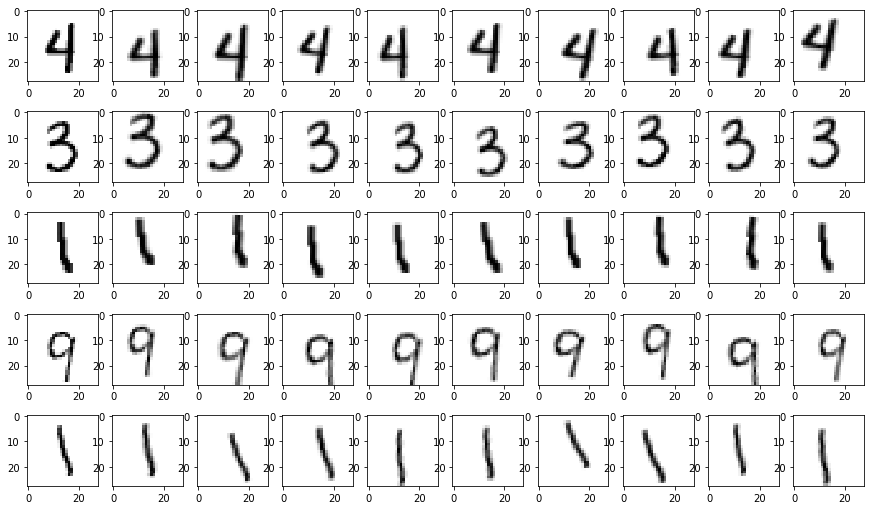

In [44]:
# generate new images via rotations, translations, zoom using keras
def generate_images(imgs):
    
    # rotations, translations, zoom
    image_generator = keras.preprocessing.image.ImageDataGenerator(
        rotation_range = 10, width_shift_range = 0.1 , height_shift_range = 0.1,
        zoom_range = 0.1)

    # get transformed images
    imgs = image_generator.flow(imgs.copy(), np.zeros(len(imgs)),
                                batch_size=len(imgs), shuffle = False).next()    
  
    return imgs[0]

# check image generation
fig,axs = plt.subplots(5,10, figsize=(15,9))
for i in range(5):
    n = np.random.randint(0,x_train.shape[0]-2)
    axs[i,0].imshow(x_train[n:n+1].reshape(28,28),cmap=cm.binary)
    axs[i,1].imshow(generate_images(x_train[n:n+1]).reshape(28,28), cmap=cm.binary)
    axs[i,2].imshow(generate_images(x_train[n:n+1]).reshape(28,28), cmap=cm.binary)
    axs[i,3].imshow(generate_images(x_train[n:n+1]).reshape(28,28), cmap=cm.binary)
    axs[i,4].imshow(generate_images(x_train[n:n+1]).reshape(28,28), cmap=cm.binary)
    axs[i,5].imshow(generate_images(x_train[n:n+1]).reshape(28,28), cmap=cm.binary)
    axs[i,6].imshow(generate_images(x_train[n:n+1]).reshape(28,28), cmap=cm.binary)
    axs[i,7].imshow(generate_images(x_train[n:n+1]).reshape(28,28), cmap=cm.binary)
    axs[i,8].imshow(generate_images(x_train[n:n+1]).reshape(28,28), cmap=cm.binary)
    axs[i,9].imshow(generate_images(x_train[n:n+1]).reshape(28,28), cmap=cm.binary)


### 새로운 image 추가

In [45]:
x_train = np.vstack([x_train,generate_images(x_train)])
y_train = np.vstack([y_train,y_train])

### 5. layer 쌓기

In [46]:
# W1의 차원은 4차원이고, kernel size는 (3,3), Channel 수 : 1, kernel 개수는 32개
# input shape : 28*28*1
regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)
L1 = tf.layers.conv2d(inputs = X
                     , filters = 32
                     , kernel_size =[3,3]
                     , padding ='SAME'
                     , kernel_initializer=tf.contrib.layers.xavier_initializer()
                      ,kernel_regularizer =regularizer
                     , activation= tf.nn.relu)
L1 = tf.layers.max_pooling2d(L1,pool_size = [2,2], strides = [2,2],padding ='SAME' ,name ='L1')
# output shape : 14,14,32 : max pooling (2,2)
# zero padding 해둔 상태에서 pooling 을 하니까 절반으로 준다.

# 2번째 layer
L2 = tf.layers.conv2d(inputs = L1
                     , filters = 32
                     , kernel_size =[3,3]
                     , padding ='SAME'
                     , kernel_initializer=tf.contrib.layers.xavier_initializer()
                     ,kernel_regularizer =regularizer
                     , activation= tf.nn.relu)
L2 = tf.layers.max_pooling2d(L2,pool_size = [2,2], strides = [2,2],padding ='SAME' ,name ='L2')
# L2 = tf.nn.dropout(L2,0.5)
# output shape : 7,7,32

# 3번째 layer
L3 = tf.layers.conv2d(inputs = L2
                     , filters = 32
                     , kernel_size =[3,3]
                     , padding ='SAME'
                     , kernel_initializer=tf.contrib.layers.xavier_initializer()
                      ,kernel_regularizer =regularizer
                     , activation= tf.nn.relu)
L3 = tf.layers.max_pooling2d(L3,pool_size = [2,2], strides = [2,2],padding ='SAME' ,name ='L3')
# L3 = tf.nn.dropout(L3,0.5)
# 4번째 layer
L4 = tf.layers.conv2d(inputs = L3
                     , filters = 32
                     , kernel_size =[3,3]
                     , padding ='SAME'
                     , kernel_initializer=tf.contrib.layers.xavier_initializer()
                      ,kernel_regularizer =regularizer
                     , activation= tf.nn.relu)
L4 = tf.layers.max_pooling2d(L4,pool_size = [2,2], strides = [2,2],padding ='SAME' ,name ='L4')

# Full connected layer
L5 = tf.contrib.layers.flatten(L4)
L5 = tf.layers.dense(L5,256, activation = tf.nn.relu)

# last layer
model = tf.layers.dense(L5, 10, activation = None)
# 학습이 잘 안되서 dropout rate를 낮췄다.
# nn.dropout은 keep할 확률을 넣는 것이고 layers dropout은 삭제할 확률을 넣는것
model = tf.layers.dropout(model,0.2)

### 6. loss function 및 optimizer

In [ ]:
cost =  tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=model, labels=  Y))
#tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=model, labels=Y))
    
optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)

# Accuarcy
# 주어진 데이터와 일치하는지 확인
correctness = tf.equal(tf.argmax(model,axis = 1),tf.argmax(Y,1))
# 일치 여부 평균내기 
accuracy = tf.reduce_mean(tf.cast(correctness, tf.float32))

predict = tf.argmax(model,axis=1)

### 7. Session

In [ ]:
init = tf.global_variables_initializer()

with tf.Session() as sess :
    sess.run(init)
    # epoch 을 줄였다! early stopping을 위해서 !
    for epoch in range(7000):
        # batch 만들기  #batch size를 키웠다
        rand_idx = np.random.choice(len(x_train),size = 1000)
        rand_x = x_train[rand_idx]
        rand_y = y_train[rand_idx]

        _, curr_loss = sess.run([optimizer, cost], feed_dict={X:rand_x, Y: rand_y})
        
        if epoch%2000 == 0 :
            print("epoch", epoch, "training error"  ,curr_loss )
    accu = sess.run(accuracy, feed_dict = {X:x_val, Y: y_val})
    prediction = sess.run(predict, feed_dict = {X:test})
    print("validation accuracy " , accu)
    

epoch 0 training error 2.3077905


### 8. Save as


In [ ]:
submission = pd.DataFrame(data={'ImageId':np.arange(1,28001), 'Label':prediction})
submission.to_csv('submission.csv', index=False)

In [ ]:
# import pandas as pd
# submit = pd.read_csv('../input/sample_submission2.csv')